In [4]:
import pandas as pd
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

In [151]:
import psycopg2
from sqlalchemy import create_engine

conn = psycopg2.connect("host=localhost dbname=movie-data user=postgres password='postgres'")
cur = conn.cursor()
#taxi_db = create_engine("sqlite:///taxi_db_l.db")

In [14]:
%%time
data_f =  pd.read_csv("C:\\Users\\nikita\\Downloads/taxi-sample.csv")
data_f = data_f.rename(columns={c: c.replace(' ', '') for c in data_f.columns})
#removing duplicates
data_f.drop_duplicates(keep='first', inplace=True)
#VendorID=4 
data_f = data_f.drop(data_f[data_f.VendorID==4].index)

# removing RateCodeID =99  
data_f = data_f.drop(data_f[data_f.RatecodeID==99].index)

#removing PULocationID =264, 265
data_f = data_f.drop(data_f[(data_f.PULocationID==264) | (data_f.PULocationID==265)].index)

#removing DOLocationID =264, 265
data_f = data_f.drop(data_f[(data_f.DOLocationID==264) | (data_f.DOLocationID==265)].index)

#removing -ve values of fare amount
data_f = data_f.drop(data_f[data_f.fare_amount<0].index)

#removing  mta_tax unknown values (other than 0,0.5)  
data_f = data_f.drop(data_f[~((data_f.mta_tax==0) | (data_f.mta_tax==0.5))].index)

#removing Extra(other than 0,0.5,1)
data_f = data_f.drop(data_f[~((data_f.extra==0) | (data_f.extra==0.5) | (data_f.extra==1))].index)

#removing Future Trips
#year + time from tpep_pickup  as a series 
col = data_f['tpep_pickup_datetime'].str.split('/')

for items in col.iteritems():
    #index
    ind = items[0]
    #year  
    yr_int= int(items[1][2].split(' ')[0])
    if yr_int > 2019:
        data_f=data_f.drop(ind)
    if yr_int == 2019:
        #month
        month_int = int(items[1][0])
        if month_int > 9:
            data_f = data_f.drop(ind)

data_f.count()

Wall time: 20 s


VendorID                 1008970
tpep_pickup_datetime     1008970
tpep_dropoff_datetime    1008970
passenger_count          1008970
trip_distance            1008970
RatecodeID               1008970
store_and_fwd_flag       1008970
PULocationID             1008970
DOLocationID             1008970
payment_type             1008970
fare_amount              1008970
extra                    1008970
mta_tax                  1008970
tip_amount               1008970
tolls_amount             1008970
improvement_surcharge    1008970
total_amount             1008970
dtype: int64

In [15]:
data_f.to_csv (r'C:\\Users\\nikita\\Downloads/taxi-sample-normalised.csv', index = None, header=True)

In [22]:
data_f.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
52,2,09/09/2019 11:33:53 AM,09/09/2019 03:10:50 PM,1,1.10,1,N,162,141,1,8.0,0.0,0.5,1.20,0.0,0.3,10.00
54,2,09/09/2019 11:07:13 AM,09/09/2019 11:26:59 AM,1,2.30,1,N,43,170,2,13.5,0.0,0.5,0.00,0.0,0.3,14.30
56,2,09/09/2019 10:42:03 AM,09/09/2019 10:53:56 AM,1,1.96,1,N,237,236,1,9.5,0.0,0.5,2.06,0.0,0.3,12.36
58,2,09/09/2019 10:19:44 AM,09/09/2019 10:31:26 AM,1,0.93,1,N,162,170,1,8.5,0.0,0.5,1.00,0.0,0.3,10.30
60,2,09/09/2019 09:44:31 AM,09/09/2019 09:50:15 AM,1,0.94,1,N,211,113,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30


In [23]:
#create table commands
cur.execute('CREATE TABLE taxisample("VendorID" integer,tpep_pickup_datetime timestamp,tpep_dropoff_datetime timestamp, passenger_count integer,trip_distance real,"RatecodeID" integer,store_and_fwd_flag varchar,PULocationID integer,DOLocationID integer,payment_type integer,fare_amount real,extra real,mta_tax real,tip_amount real,tolls_amount real,improvement_surcharge real,total_amount real)')
conn.commit()

In [24]:
%%time
#copy csv to postgresql
with open("C:\\Users\\nikita\\Downloads/taxi-sample-normalised.csv", 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'taxisample', sep=',')
    conn.commit()

Wall time: 16.8 s


In [26]:
cur.execute('SELECT count(store_and_fwd_flag) FROM taxisample')
imax = cur.fetchall()
imax

[(1008970,)]

In [31]:
import geopandas as gp
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt

In [33]:
df = gp.read_file("C:\\Users\\nikita\\Downloads\\taxi_zones/taxi_zones.shp")
df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [59]:
# poor connectivity
cur.execute("select DOLocationID from taxisample where Store_and_fwd_flag='Y'")

result = list(dict.fromkeys(cur))
result.sort()

#locations where connectivity is poor = results

print(len(result))
print(len(df))

170
263


In [115]:
%%time
import numpy as np
poor_connectivity = []
min_df = df['LocationID']

for j in range(len(min_df)):
    if np.isin(min_df[j],result):
        poor_connectivity.append(1000)
    else:
        poor_connectivity.append(100)
df['poor_connectivity'] = poor_connectivity
df.head()

Wall time: 80 ms


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,poor_connectivity
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",1000
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",100
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",100
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1000
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",1000


Text(0.5, 1, 'Regions of NYC with poor connectivity')

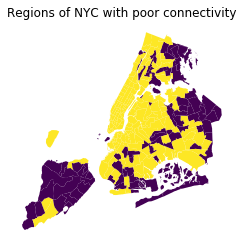

In [148]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
plt.axis('off')
df.plot(column='poor_connectivity', ax=ax, legend=False, figsize=(8, 4));
plt.title("Regions of NYC with poor connectivity")

In [153]:
cur.execute('SELECT distinct PULocationID,DOLocationID,Tolls_amount FROM taxisample where Tolls_amount > 0')
imax = cur.fetchall()
imax

[(162, 67, 5.76),
 (231, 26, 5.76),
 (138, 250, 5.76),
 (161, 241, 2.64),
 (162, 101, 5.76),
 (28, 143, 5.76),
 (170, 84, 17.28),
 (161, 10, 5.76),
 (186, 1, 12.66),
 (74, 260, 5.76),
 (238, 51, 2.64),
 (219, 75, 5.76),
 (100, 188, 5.76),
 (138, 234, 5.76),
 (179, 262, 5.76),
 (100, 138, 5.57),
 (259, 231, 5.76),
 (68, 51, 2.64),
 (80, 41, 5.76),
 (208, 83, 5.76),
 (100, 22, 5.76),
 (163, 47, 2.64),
 (42, 82, 5.76),
 (211, 1, 18.0),
 (100, 95, 5.76),
 (246, 138, 5.76),
 (230, 171, 5.76),
 (26, 87, 5.76),
 (158, 1, 15.5),
 (140, 82, 5.76),
 (107, 155, 5.76),
 (132, 249, 5.76),
 (48, 256, 5.76),
 (186, 248, 5.76),
 (163, 223, 5.76),
 (261, 138, 5.76),
 (138, 167, 5.76),
 (230, 1, 14.7),
 (116, 138, 5.76),
 (163, 115, 11.52),
 (127, 76, 5.76),
 (161, 1, 18.18),
 (186, 95, 5.76),
 (95, 142, 5.76),
 (156, 14, 11.52),
 (162, 1, 15.0),
 (145, 224, 5.76),
 (132, 240, 5.76),
 (164, 161, 5.76),
 (100, 165, 5.76),
 (134, 134, 5.76),
 (182, 19, 5.76),
 (100, 252, 5.76),
 (75, 151, 5.76),
 (170, 91